# 🧭 Setup and Configuration

This block imports required libraries and utility functions for analysis.
It sets the parameters for:
- the log directory of simulation outputs,
- demand mode ("synthetic" or "real"),
- list of relocation strategies to analyze,
- region ID to visualize,
- time bin width (in minutes) for time series plots.


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import collections
from datetime import timedelta
import json # Use json instead of eval if possible

from utils import (
    plot_simulation_grid_for_strategies,
    compute_metrics,
    calculate_regional_abandonment,
    find_worst_region_for_strategy,
)

from constants import (
    TIME_BLOCK_BOUNDARY,
    RIDER_ARRIVAL,
    RIDER_LOST,
    RIDE_COMPLETION,
    RELOCATION_COMPLETION,
    RELOCATION_START,
    RIDE_START,
    TAXI_INIT,
    location_ids,
)

# Assume the dataframes are saved in CSV format under this directory
log_dir = "sim_outputs"
demand_mode = "synthetic"  # or "real"
strategies = ["no_reloc", "JLCR", "shortest_wait", "Q_2", "Q_4", "Q_8"]
region_id = 48  # example region
bin_minutes = 20

# 📈 Plot Rider Demand and Service Over Time (Per Strategy)

This block produces a 3×2 grid of time series plots for a fixed demand mode (synthetic/real),
comparing how each relocation strategy performed over time in a given region.

Each subplot shows:
- Number of rider arrivals,
- Number of ride starts (fulfilled),
- Number of lost riders (unserved).

The system warm-up period is excluded from the plot.

Choose region where `no_reloc` strategy suffered the most.

Analyzing baseline strategy file: sim_outputs/0/real_demand__JLCR.csv
Identified Region 28 as having the highest abandonment rate (0.6905) for strategy 'JLCR'.
Plot saved to real_comparison_region_34_run_0.png


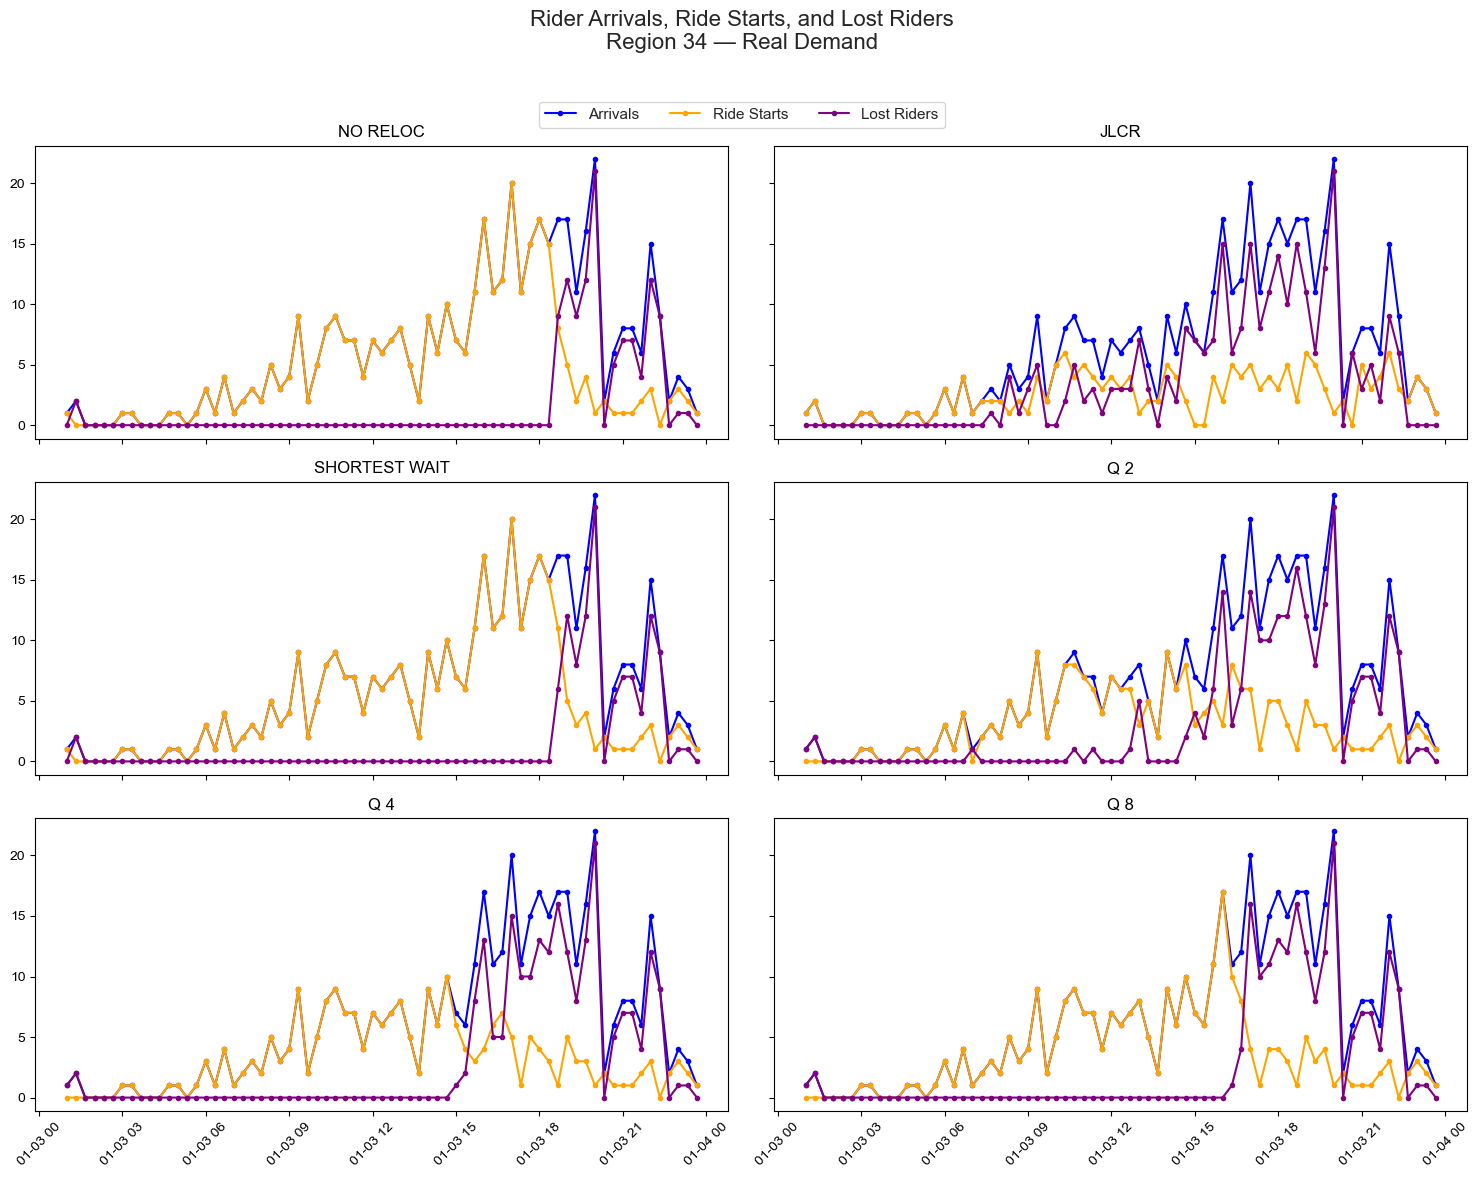

In [2]:
# --- Example Workflow ---

# Define parameters
demand_mode_to_analyze = 'real' # Or 'real'
baseline_strategy = 'JLCR'
all_strategies_to_plot = ["no_reloc", "JLCR", "shortest_wait", "Q_2", "Q_4", "Q_8"]
run_number_to_analyze = 0 # Choose which run (n) to analyze for picking the region

# 1. Find the worst region for the baseline strategy
target_region_id = find_worst_region_for_strategy(
    demand_mode=demand_mode_to_analyze,
    strategy=baseline_strategy,
    n=run_number_to_analyze
)

data_cache = plot_simulation_grid_for_strategies(
    demand_mode=demand_mode_to_analyze,
    strategies=all_strategies_to_plot,
    region_id=target_region_id,
    bin_minutes=20, # Or your desired bin size
    log_dir="sim_outputs",
    filename=f"{demand_mode_to_analyze}_comparison_region_{location_ids[target_region_id]}_run_{run_number_to_analyze}.png",
    n=run_number_to_analyze,
    ignore_days=1
)


Analyzing baseline strategy file: sim_outputs/0/real_demand__no_reloc.csv
Identified Region 196 as having the highest abandonment rate (0.4567) for strategy 'no_reloc'.
Plot saved to real_comparison_region_224_run_0_2.png


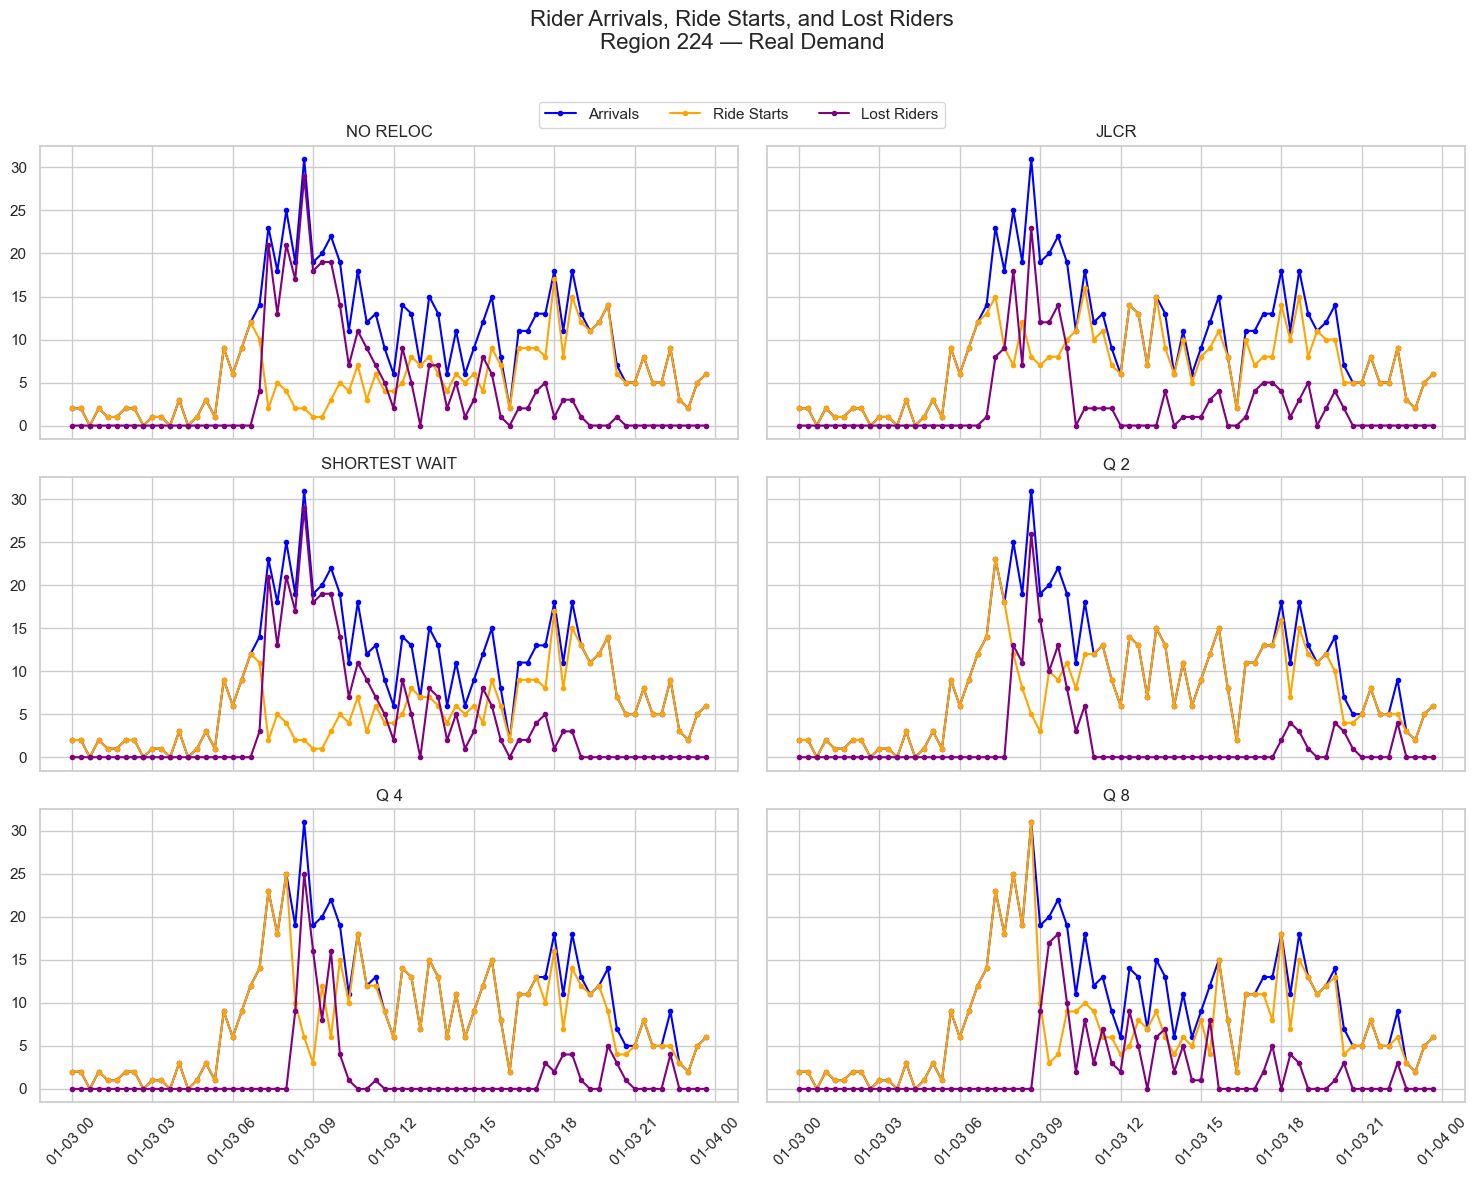

In [7]:
# --- Example Workflow ---

# Define parameters
demand_mode_to_analyze = 'real' # Or 'real'
baseline_strategy = 'no_reloc'
all_strategies_to_plot = ["no_reloc", "JLCR", "shortest_wait", "Q_2", "Q_4", "Q_8"]
run_number_to_analyze = 0 # Choose which run (n) to analyze for picking the region

# 1. Find the worst region for the baseline strategy
target_region_id = find_worst_region_for_strategy(
    demand_mode=demand_mode_to_analyze,
    strategy=baseline_strategy,
    n=run_number_to_analyze
)

data_cache2 = plot_simulation_grid_for_strategies(
    demand_mode=demand_mode_to_analyze,
    strategies=all_strategies_to_plot,
    region_id=target_region_id,
    bin_minutes=20, # Or your desired bin size
    log_dir="sim_outputs",
    filename=f"{demand_mode_to_analyze}_comparison_region_{location_ids[target_region_id]}_run_{run_number_to_analyze}_2.png",
    n=run_number_to_analyze,
    ignore_days=1
)


# 📋 System Metrics for a Single Run

This block loads a single simulation log (e.g. JLCR under synthetic demand)
and computes **9 scalar system-level performance metrics** using `compute_system_metrics()`:

- `abandonment_rate`: riders lost ÷ total requests
- `utilization_rate`: time spent on trips ÷ total vehicle time
- `idle_time_ratio`: idle time ÷ total vehicle time
- `relocation_time_ratio`: relocation time ÷ total vehicle time
- `temporal_max_abandonment_rate`: highest temporal loss rate
- `regional_max_abandonment_rate`: highest regional loss rate
- `maximal_average_queue_length`: average queue length


In [ ]:
demand_mode = "real"
n = 0
strat = "JLCR" # ["no_reloc", "JLCR", "shortest_wait", "Q_2", "Q_4", "Q_8"]

df_log = pd.read_csv(f"sim_outputs/{n}/{demand_mode}_demand__{strat}.csv", converters={"data": eval})
# df_log['datetime'] = pd.to_timedelta(df_log['time'], unit='h') + pd.Timestamp("2025-01-02")

In [ ]:
def get_metric(demand_mode, n, strat):
    df_log = pd.read_csv(f"sim_outputs/{n}/{demand_mode}_demand__{strat}.csv", converters={"data": eval})
    metrics = compute_metrics(df_log)
    return metrics

# demand_mode = "real"
# n = 0
# strat = "JLCR" # ["no_reloc", "JLCR", "shortest_wait", "Q_2", "Q_4", "Q_8"]
# metrics = get_metric(demand_mode, n, strat)

# 📊 Aggregate Metrics Across Multiple Simulation Runs

This block computes the same 9 metrics as above, but averaged across multiple repeated runs
of the same setting (e.g. 20 CSV files of 'synthetic_demand__no_reloc.csv').

The output is a table showing:
- Mean value for each metric across runs,
- Standard deviation across runs (useful to assess reliability/stability of the strategy).


In [ ]:
# --- Define Simulation Parameters ---
# demand_modes = ["real", "synthetic"]
demand_modes = ["real"] # Example: Use only one for testing
strats = ["no_reloc", "JLCR", "shortest_wait", "Q_2", "Q_4", "Q_8"]
N = 5 # Number of runs per combination (e.g., n goes from 0 to 9)

# --- Main Loop to Collect Metrics ---
all_results = []

for mode in demand_modes:
    for strategy in strats:
        print(f"\nProcessing: Mode={mode}, Strategy={strategy}")
        run_metrics_list = []
        for i in range(N): # Iterate through runs n=0 to N-1
            metrics = get_metric(mode, i, strategy)
            if metrics is not None:
                run_metrics_list.append(metrics)

        if not run_metrics_list:
            print(f"Warning: No successful runs found for Mode={mode}, Strategy={strategy}")
            continue

        # --- Process Metrics for this combination ---
        # Convert list of dictionaries to DataFrame
        df_runs = pd.DataFrame(run_metrics_list)

        # Handle special case: regional_max_abandonment_rate (extract value)
        metric_col_regional = 'regional_max_abandonment_rate'
        metric_col_regional_val = f'{metric_col_regional}_val' # New column name

        if metric_col_regional in df_runs.columns:
            # Check if it contains tuples/lists before applying extraction
            is_tuple_list = df_runs[metric_col_regional].apply(lambda x: isinstance(x, (tuple, list))).any()
            if is_tuple_list:
                 print(f"Extracting value from '{metric_col_regional}' into '{metric_col_regional_val}'")
                 df_runs[metric_col_regional_val] = df_runs[metric_col_regional].apply(
                    lambda x: x[0] if isinstance(x, (tuple, list)) and len(x) > 0 and isinstance(x[0], (int, float)) else np.nan
                 )
                 # Identify numeric columns *excluding* the original tuple column
                 numeric_cols = df_runs.select_dtypes(include=np.number).columns.tolist()
                 # Ensure the newly created value column is included if it wasn't automatically picked up
                 if metric_col_regional_val not in numeric_cols and metric_col_regional_val in df_runs.columns:
                     numeric_cols.append(metric_col_regional_val)

            else: # If it's already numeric, just use it directly
                 print(f"Column '{metric_col_regional}' seems to be already numeric.")
                 numeric_cols = df_runs.select_dtypes(include=np.number).columns.tolist()
        else:
             # If column doesn't exist, just get numeric cols
             numeric_cols = df_runs.select_dtypes(include=np.number).columns.tolist()


        # Calculate mean and std dev for all numeric columns found
        if numeric_cols:
             means = df_runs[numeric_cols].mean()
             stds = df_runs[numeric_cols].std()

             # Store results
             result_summary = {
                 'demand_mode': mode,
                 'strategy': strategy,
                 'num_successful_runs': len(df_runs)
             }
             for metric in numeric_cols:
                 result_summary[f'{metric}_mean'] = means.get(metric, np.nan)
                 result_summary[f'{metric}_std'] = stds.get(metric, np.nan)

             all_results.append(result_summary)
        else:
            print(f"Warning: No numeric metrics found to aggregate for Mode={mode}, Strategy={strategy}")


# --- Create Final Summary DataFrame ---
if all_results:
    summary_df = pd.DataFrame(all_results)
    summary_df = summary_df.set_index(['demand_mode', 'strategy'])
    print("\n\n--- Summary Statistics (Mean and Std Dev across runs) ---")
    print(summary_df)

    # Optionally display mean and std separately for clarity
    mean_cols = [col for col in summary_df.columns if col.endswith('_mean')]
    std_cols = [col for col in summary_df.columns if col.endswith('_std')]

    print("\n--- Mean Metrics ---")
    print(summary_df[mean_cols])

    print("\n--- Standard Deviation Metrics ---")
    print(summary_df[std_cols])
else:
    print("\nNo results were aggregated.")
    
summary_df.to_csv("summary_results.csv", index=True)

In [ ]:
summary_df.round(2)